---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10.

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**.


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чтем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е.

In [1]:
import torch
import torchvision
from torchvision.transforms import v2 as transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [2]:
transform = transforms.Compose(  # то, что нужно сделать с картинкой
    [transforms.ToImage(),
     transforms.ToDtype(torch.float32)])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)  # num_workers - количество ядер для загрузки сета через мультипроцессинг

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в поле `trainloader.dataset.data`

In [3]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [4]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

Выведем первую картинку:

In [5]:
trainloader.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [6]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.data[0].numpy()

In [7]:
numpy_img.shape

(28, 28)

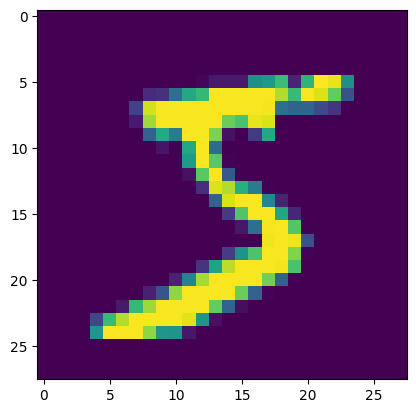

In [8]:
plt.imshow(numpy_img);

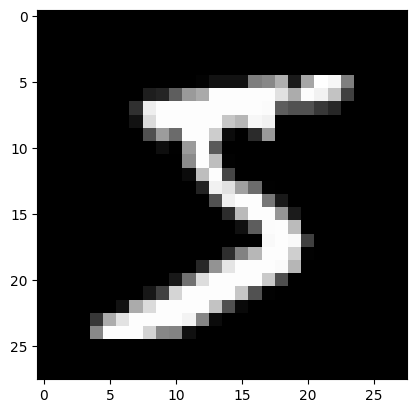

In [9]:
plt.imshow(numpy_img, cmap='gray');

In [10]:
next(iter(trainloader))[0].shape  # размер данный по батчам

torch.Size([4, 1, 28, 28])

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [11]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [12]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()

        '''
        Давайте разберём каждый слой нейронной сети:

        1) Входной тензор: Предположим, у нас есть изображения размера 28x28 и одного канала (чёрно-белые). То есть размер входного тензора будет [batch_size, 1, 28, 28].

        2) Первая свёртка (self.conv1): Свертка с 6 фильтрами и ядром размера 5x5. Выходная размерность будет [batch_size, 6, 24, 24] (28 - 5 + 1 = 24). Количество нейронов: 6 * 24 * 24 = 3456
        3) Первый пулинг (self.pool): MaxPooling со stride 2 и ядром 2x2. Это уменьшит размер каждого канала в 2 раза: [batch_size, 6, 12, 12]. Количество нейронов: 6 * 12 * 12 = 864

        4) Вторая свёртка (self.conv2): Свертка с 16 фильтрами и ядром 5x5. Выходная размерность будет [batch_size, 16, 8, 8] (12 - 5 + 1 = 8). Количество нейронов: 16 * 8 * 8 = 1024
        5) Второй пулинг (self.pool): Ещё один MaxPooling со stride 2 и ядром 2x2. Это снова уменьшит размер каждого канала в 2 раза: [batch_size, 16, 4, 4]. Количество нейронов: 16 * 4 * 4 = 256

        6) Первый полносвязный слой (self.fc1): Входная размерность 256 (16 * 4 * 4), выходная — 120.
        7) Второй полносвязный слой (self.fc2): Входная размерность 120, выходная — 84.
        8) Второй полносвязный слой (self.fc3): Входная размерность 84, выходная — 10. (количество классов)
        '''

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # объяснение в комментарии выше
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # первый слой свертки
        x = self.pool(F.relu(self.conv2(x)))  # второй слой свертки

        # x = x.view(-1, x.shape[0] * x.shape[1] * x.shape[2])
        x = x.view(-1, 4 * 4 * 16)  # вытягиваем выход сверток в один вектор размера (batch_size; n_out_features); flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = SimpleConvNet()

summary(net.cuda(), (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           156
├─MaxPool2d: 1-2                         [-1, 6, 12, 12]           --
├─Conv2d: 1-3                            [-1, 16, 8, 8]            2,416
├─MaxPool2d: 1-4                         [-1, 16, 4, 4]            --
├─Linear: 1-5                            [-1, 120]                 30,840
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (M): 0.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           156
├─MaxPool2d: 1-2                         [-1, 6, 12, 12]           --
├─Conv2d: 1-3                            [-1, 16, 8, 8]            2,416
├─MaxPool2d: 1-4                         [-1, 16, 4, 4]            --
├─Linear: 1-5                            [-1, 120]                 30,840
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (M): 0.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21

In [14]:
batch = next(iter(trainloader))

net.forward(batch[0].cuda())

tensor([[-1.5351,  5.9245,  0.8796,  3.7498, -2.3889, -0.7370,  6.8572, -8.5205,
          2.1547, -6.9704],
        [-0.8773,  8.6431,  2.6322,  2.8806, -0.2159,  1.0818,  7.2550, -6.6503,
          0.4577, -4.7583],
        [-1.3837,  3.5481, -0.2018,  2.4111, -1.2424,  0.1569,  6.9176, -6.7724,
         -0.5959, -6.6603],
        [-1.5071, 10.4230, -0.2666,  1.6786, -1.2703,  1.2230,  6.0737, -5.4483,
         -0.6588, -7.9789]], device='cuda:0', grad_fn=<AddmmBackward0>)

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [15]:
from tqdm import tqdm

In [171]:
# объявляем сеть
net = SimpleConvNet().to(device)

In [172]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [173]:
from sklearn.metrics import precision_score, recall_score

In [174]:
import torch
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, test_loader, 
                 epochs=100, patience=5, scheduler=None, callbacks=None, average='binary',
                 device='cuda'):
        # Приватные атрибуты
        self._model = model
        self._criterion = criterion
        self._optimizer = optimizer
        self._train_loader = train_loader
        self._test_loader = test_loader
        self._epochs = epochs
        self._scheduler = scheduler
        self._patience = patience
        self._device = device

        # История метрик
        self._history = {'train_losses': [], 'valid_losses': [], 'train_accuracies': [], 'valid_accuracies': []}
        if callbacks is not None:
            self._history.update({'valid_' + call.__name__: [0] for call in callbacks})
            self._history.update({'train_' + call.__name__: [0] for call in callbacks})

        self._callbacks = callbacks
        self._average = average
            
        self._best_loss = float('inf')
        self._best_acc = 0

    # Свойства для доступа к выбранным атрибутам
    @property
    def history(self):
        return self._history

    @property
    def model(self):
        return self._model

    @property
    def best_loss(self):
        return self._best_loss

    @property
    def best_acc(self):
        return self._best_acc

    @property
    def epochs(self):
        return self._epochs

    def train_model(self):
        self._model.to(self._device)
        epochs_without_improvement = 0

        for epoch in range(self._epochs):
            start_time = time.time()

            # Training phase
            self._model.train()
            running_loss, correct, total, num_batches = 0.0, 0, 0, 0

            pbar = tqdm(self._train_loader, desc=f'Training Epoch {epoch + 1}/{self._epochs}', leave=False)
            for inputs, labels in pbar:
                num_batches += 1
                inputs, labels = inputs.to(self._device), labels.to(self._device)

                self._optimizer.zero_grad()
                outputs = self._model(inputs)
                loss = self._criterion(outputs, labels)
                loss.backward()
                self._optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Обновляем текущий loss в tqdm
                current_loss = running_loss / num_batches
                current_accuracy = correct / total

                mes = f'Training Epoch {epoch + 1}/{self._epochs} - Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}'
                if self._callbacks is not None:
                    for call in self._callbacks:
                        metric = call(predicted.to('cpu'), labels.to('cpu'), average=self._average)
                        self._history['train_' + call.__name__][-1] += metric
                        mes += f' {call.__name__.capitalize()}: {metric}'
                pbar.set_description(mes)
                    

            train_loss = running_loss / num_batches
            train_accuracy = correct / total
            self._history['train_losses'].append(train_loss)
            self._history['train_accuracies'].append(train_accuracy)
            for call in self._callbacks:
                self._history['train_' + call.__name__][-1] /= num_batches

            # Validation phase
            self._model.eval()
            running_loss, correct, total, num_batches = 0.0, 0, 0, 0

            with torch.no_grad():
                pbar = tqdm(self._test_loader, desc='Validating', leave=False)
                for inputs, labels in pbar:
                    num_batches += 1
                    inputs, labels = inputs.to(self._device), labels.to(self._device)
                    outputs = self._model(inputs)
                    loss = self._criterion(outputs, labels)

                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    if self._callbacks is not None:
                        for call in self._callbacks:
                            metric = call(predicted.to('cpu'), labels.to('cpu'), average=self._average)
                            self._history['valid_' + call.__name__][-1] += metric

            valid_loss = running_loss / num_batches
            valid_accuracy = correct / total
            self._history['valid_losses'].append(valid_loss)
            self._history['valid_accuracies'].append(valid_accuracy)
            for call in self._callbacks:
                self._history['valid_' + call.__name__][-1] /= num_batches

            # Early stopping
            if valid_loss < self._best_loss:
                self._best_loss = valid_loss
                self._best_acc = valid_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= self._patience:
                print(f'\nEarly stopping triggered after {epoch} epochs')
                break

            # Шаг scheduler
            if self._scheduler:
                try:
                    self._scheduler.step()
                except Exception as e:
                    print(f'Error running scheduler: {e}')

            end_time = time.time()
            epoch_time = end_time - start_time

            display = f'Epoch {epoch + 1}/{self._epochs} -'
            
            for name, metric in self._history.items():
                if name.startswith('train'):
                    display += f" {' '.join(i.capitalize() for i in name.split('_'))}: {round(metric[0], 3)}, "
                    display += f" {' '.join(i.capitalize() for i in ['valid'] + name.split('_')[1:])}: {round(self._history['_'.join(['valid'] + name.split('_')[1:])][0], 3)}, "
            display += f'Time: {epoch_time:.2f}s'

            print(display)



    def plot_metrics(self):
        train_losses = self._history['train_losses']
        valid_losses = self._history['valid_losses']
        train_accuracies = self._history['train_accuracies']
        valid_accuracies = self._history['valid_accuracies']

        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', color='blue')
        plt.plot(epochs, valid_losses, label='Valid Loss', color='orange')
        plt.title('Train and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
        plt.plot(epochs, valid_accuracies, label='Valid Accuracy', color='orange')
        plt.title('Train and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
import torch
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import warnings

# Отключение предупреждений
warnings.filterwarnings("ignore")

class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, test_loader,
                 epochs=100, patience=5, scheduler=None, callbacks=None, average='binary',
                 device='cuda'):
        self._model = model
        self._criterion = criterion
        self._optimizer = optimizer
        self._train_loader = train_loader
        self._test_loader = test_loader
        self._epochs = epochs
        self._scheduler = scheduler
        self._patience = patience
        self._device = device

        # История метрик
        self._history = {'train_losses': [], 'valid_losses': [], 'train_accuracies': [], 'valid_accuracies': []}
        if callbacks is not None:
            self._history.update({'valid_' + call.__name__: [0] for call in callbacks})
            self._history.update({'train_' + call.__name__: [0] for call in callbacks})

        self._callbacks = callbacks
        self._average = average
        self._best_loss = float('inf')
        self._best_acc = 0

    @property
    def history(self):
        return self._history

    @property
    def model(self):
        return self._model

    @property
    def best_loss(self):
        return self._best_loss

    @property
    def best_acc(self):
        return self._best_acc

    @property
    def epochs(self):
        return self._epochs

    def train_model(self):
        self._model.to(self._device)
        epochs_without_improvement = 0

        for epoch in range(self._epochs):
            start_time = time.time()

            train_loss, train_accuracy = self._train_one_epoch(epoch)
            valid_loss, valid_accuracy = self._validate_one_epoch()

            self._history['train_losses'].append(train_loss)
            self._history['train_accuracies'].append(train_accuracy)
            self._history['valid_losses'].append(valid_loss)
            self._history['valid_accuracies'].append(valid_accuracy)

            for call in self._callbacks or []:
                self._history['train_' + call.__name__][-1] /= len(self._train_loader)
                self._history['valid_' + call.__name__][-1] /= len(self._test_loader)

            if valid_loss < self._best_loss:
                self._best_loss = valid_loss
                self._best_acc = valid_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= self._patience:
                print(f'\nEarly stopping triggered after {epoch + 1} epochs')
                break

            if self._scheduler:
                try:
                    self._scheduler.step()
                except Exception as e:
                    print(f'Error running scheduler: {e}')

            epoch_time = time.time() - start_time
            self._print_epoch_summary(epoch, epoch_time)

    def _train_one_epoch(self, epoch):
        self._model.train()
        running_loss, correct, total = 0.0, 0, 0

        pbar = tqdm(self._train_loader, desc=f'Training Epoch {epoch + 1}/{self._epochs}', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(self._device), labels.to(self._device)
            self._optimizer.zero_grad()

            outputs = self._model(inputs)
            loss = self._criterion(outputs, labels)
            loss.backward()
            self._optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            current_loss = running_loss / (total / labels.size(0))
            current_accuracy = correct / total

            # Описание с текущими метриками
            mes = f'Training Epoch {epoch + 1}/{self._epochs} - Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}'
            if self._callbacks:
                for call in self._callbacks:
                    metric = call(predicted.to('cpu'), labels.to('cpu'), average=self._average)
                    self._history['train_' + call.__name__][-1] += metric
                    mes += f' {call.__name__.capitalize()}: {metric:.4f}'

            pbar.set_description(mes)

        return running_loss / len(self._train_loader), correct / total

    def _validate_one_epoch(self):
        self._model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            pbar = tqdm(self._test_loader, desc='Validating', leave=False)
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self._device), labels.to(self._device)
                outputs = self._model(inputs)
                loss = self._criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for call in self._callbacks or []:
                    metric = call(predicted.to('cpu'), labels.to('cpu'), average=self._average)
                    self._history['valid_' + call.__name__][-1] += metric

        return running_loss / len(self._test_loader), correct / total

    def _print_epoch_summary(self, epoch, epoch_time):
        display = f'Epoch {epoch + 1}/{self._epochs} -'
            
        for name, metric in self._history.items():
            if name.startswith('train'):
                display += f" {' '.join(i.capitalize() for i in name.split('_'))}: {round(metric[0], 3)}, "
                display += f" {' '.join(i.capitalize() for i in ['valid'] + name.split('_')[1:])}: {round(self._history['_'.join(['valid'] + name.split('_')[1:])][0], 3)}, "
        display += f'Time: {epoch_time:.2f}s'

        print(display)

    def plot_metrics(self):
        fig, axes = plt.subplots(1, len(list(self._history.keys())) // 2, figsize=(6, 9))

        epochs = range(1, self._epochs+1)
        default_metrics = ['losses', 'accuracies']
        for ax, call in zip(axes, default_metrics + self._callbacks):
            name = call.__name__ if call not in default_metrics else call
            train_metric = self._history[f'train_{name}']
            valid_metric = self._history[f'valid_{name}']
            ax.plot(epochs, train_metric, label=f'train', color='blue')
            ax.plot(epochs, valid_metric, label=f'valid', color='orange')
            ax.set_title(name)
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Value')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

In [176]:
trainer = Trainer(model=net,
                  train_loader=trainloader,
                  test_loader=testloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=5,
                  callbacks=[precision_score, recall_score],
                  average='weighted')
trainer.train_model()

Epoch 1/5 - Train Losses: 0.189,  Valid Losses: 0.084,  Train Accuracies: 0.941,  Valid Accuracies: 0.975,  Train Precision Score: 0.949,  Valid Precision Score: 0.978,  Train Recall Score: 0.941,  Valid Recall Score: 0.975, Time: 83.05s


Epoch 2/5 - Train Losses: 0.189,  Valid Losses: 0.084,  Train Accuracies: 0.941,  Valid Accuracies: 0.975,  Train Precision Score: 0.982,  Valid Precision Score: 0.982,  Train Recall Score: 0.98,  Valid Recall Score: 0.978, Time: 81.53s


Epoch 3/5 - Train Losses: 0.189,  Valid Losses: 0.084,  Train Accuracies: 0.941,  Valid Accuracies: 0.975,  Train Precision Score: 0.988,  Valid Precision Score: 0.989,  Train Recall Score: 0.986,  Valid Recall Score: 0.986, Time: 81.80s


Epoch 4/5 - Train Losses: 0.189,  Valid Losses: 0.084,  Train Accuracies: 0.941,  Valid Accuracies: 0.975,  Train Precision Score: 0.99,  Valid Precision Score: 0.986,  Train Recall Score: 0.989,  Valid Recall Score: 0.984, Time: 83.85s


Epoch 5/5 - Train Losses: 0.189,  Valid Losses: 0.084,  Train Accuracies: 0.941,  Valid Accuracies: 0.975,  Train Precision Score: 0.992,  Valid Precision Score: 0.99,  Train Recall Score: 0.991,  Valid Recall Score: 0.988, Time: 84.43s


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

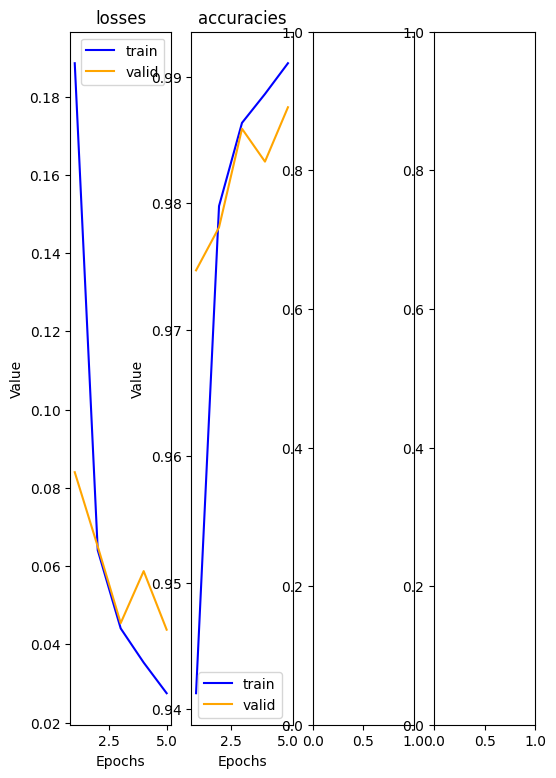

In [177]:
trainer.plot_metrics()

  0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 0.498
[1,  4000] loss: 0.210
[1,  6000] loss: 0.164
[1,  8000] loss: 0.135
[1, 10000] loss: 0.122
[1, 12000] loss: 0.120
[1, 14000] loss: 0.101


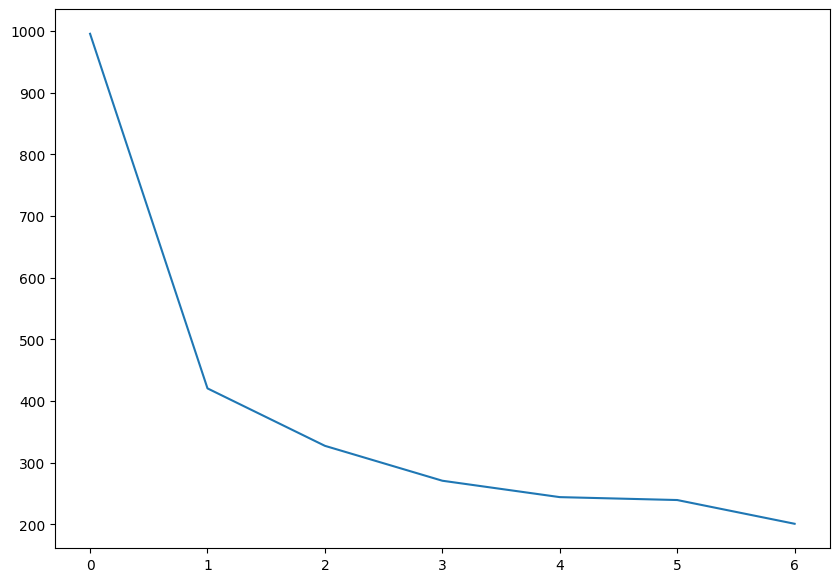

 50%|█████     | 1/2 [01:08<01:08, 68.79s/it]

[2,  2000] loss: 0.069
[2,  4000] loss: 0.077
[2,  6000] loss: 0.069
[2,  8000] loss: 0.074
[2, 10000] loss: 0.064
[2, 12000] loss: 0.064
[2, 14000] loss: 0.072


100%|██████████| 2/2 [02:34<00:00, 77.05s/it]

Обучение закончено


In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

# итерируемся
for epoch in tqdm(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(trainloader):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))  # делим на 2000, потому что информация относительно 2000 батчей выводится
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [147]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)

        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %


---

### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [149]:
transform = transforms.Compose(
    [transforms.ToImage(),
     transforms.ToDtype(torch.float32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13067485.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [151]:
trainloader.dataset.data.shape

(50000, 32, 32, 3)

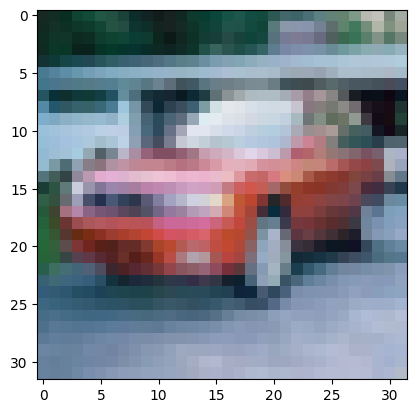

In [150]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 128), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели.

К делу:

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [152]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 32, 32])

In [161]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 3),
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)  # !!!
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #(32,32)
        x = self.pool(F.relu(self.conv1(x)))
        #(14,14)
        x = self.pool(F.relu(self.conv2(x)))
        #(6,6)
        #print(x.shape)
        x = x.view(-1, 6 * 6 * 128)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [162]:
# пример взят из официального туториала:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(trainloader):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

100%|██████████| 10/10 [02:39<00:00, 15.98s/it]

Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [163]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 89 %
Accuracy of  bird : 57 %
Accuracy of   cat : 58 %
Accuracy of  deer : 51 %
Accuracy of   dog : 42 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 84 %
Accuracy of truck : 74 %


Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [ ]:
# Ваш код здесь

(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M